# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils import data as torch_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from typing import Final
import pandas as pd
import dataclasses
from etils import epath
import torch_scatter
import gc
from tqdm.notebook import tqdm
from graphmodels import featurizer
from graphmodels import constants
from graphmodels import datasets
from graphmodels import data_utils
from graphmodels import models
from graphmodels.layers import graph_attention_layers
from graphmodels.models import gat
from torch.utils.data import DataLoader, Dataset
from sklearn import model_selection as sk_modelselection
from sklearn import metrics as sk_metrics

from torch_geometric import nn as geom_nn
from torch_geometric.loader import DataLoader as GeomDataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import PPI
from torch_geometric.nn import models




from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
print(torch.cuda.is_available())

True


In [2]:
DATAPATH: epath.Path = epath.Path("../datasets/chemistry/")
df = pd.read_csv(DATAPATH/"delaney-processed_clean.csv")
df["mol"] = df["RDKIT_SMILES"].apply(Chem.MolFromSmiles)
df["num_bonds"] = df["mol"].apply(lambda x : x.GetNumBonds())
df = df.loc[df["num_bonds"]>=1]

In [3]:
# Split data
train_df, test_df = sk_modelselection.train_test_split(
    df, test_size=0.3, random_state=42, shuffle=True,
    #stratify=df["measured log solubility in mols per litre"]
)
train_df, valid_df = sk_modelselection.train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    #stratify=train_df["measured log solubility in mols per litre"],
)

In [4]:
LABEL: str = "measured log solubility in mols per litre"
SMILES: str = "smiles"
train_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(train_df[SMILES]),
                                               targets=tuple(train_df[LABEL]),
                                 add_master_node=False)

valid_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(valid_df[SMILES]),
                                               targets=tuple(valid_df[LABEL]),
                                 add_master_node=False)

test_dset = datasets.mpnn_dataset.MPNNDataset(smiles=tuple(test_df[SMILES]),
                                               targets=tuple(test_df[LABEL]),
                                add_master_node=False)


train_dataloader = DataLoader(dataset=train_dset,
                              batch_size=32,
                              shuffle=True,
                              collate_fn=data_utils.mpnn_collate_diag,
                             )

valid_dataloader = DataLoader(dataset=valid_dset,
                              batch_size=64,
                              shuffle=False,
                              collate_fn=data_utils.mpnn_collate_diag,
                             )

test_dataloader = DataLoader(dataset=test_dset,
                              batch_size=64,
                              shuffle=False,
                              collate_fn=data_utils.mpnn_collate_diag,
                            )


#dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
# train_dset = PPI(root='/tmp/PPI', split='train')
# val_dset = PPI(root='/tmp/PPI', split='val')
# test_dset = PPI(root='/tmp/PPI', split='test')


# # Create data loaders
# train_loader = GeomDataLoader(train_dset, batch_size=16, shuffle=True)
# val_loader = GeomDataLoader(val_dset, batch_size=32, shuffle=False)
# test_loader = GeomDataLoader(test_dset, batch_size=32, shuffle=False)

# # Extract labels for stratified splitting
# labels = [data.y.item() for data in dataset]

# # First split: train vs temp (val + test)
# train_idx, temp_idx = sk_modelselection.train_test_split(
#     list(range(len(dataset))),
#     test_size=0.3,
#     stratify=labels,
#     random_state=42,
# )

# # Second split: val vs test from temp
# temp_labels = [labels[i] for i in temp_idx]
# val_idx, test_idx = sk_modelselection.train_test_split(
#     temp_idx,
#     test_size=0.5,
#     stratify=temp_labels,
#     random_state=42,
# )

# # Create the datasets
# train_dataset = dataset[train_idx]
# val_dataset = dataset[val_idx]
# test_dataset = dataset[test_idx]

# # Create data loaders
# train_loader = GeomDataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = GeomDataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = GeomDataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
train_dset[0].edge_features.shape

torch.Size([18, 24])

In [6]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                valid_loader: DataLoader,
                loss_fn: torch.nn.modules.loss,
                epochs: int=10,
                lr: float=1e-3,
                max_learning_rate: float=1e-2,
                weight_decay: float=0.1,
                device: str='cuda'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_learning_rate, steps_per_epoch=len(train_loader), epochs=epochs)
    
    history = []

    model.to(device)
    print("🚀 Starting training...\n")
    pbar = tqdm(total=epochs, desc="Training")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, train_batch in enumerate(train_loader):
            atom_feats = train_batch.node_features.to(device)
            #bond_features =  batch.edge_features.to(device)
            edge_index = train_batch.edge_index.to(device)
            labels = train_batch.targets.to(device)
            batch_vector = train_batch.batch_vector.to(device)

            optimizer.zero_grad()
            outputs = model(node_features=atom_feats, edge_index=edge_index, batch_vector=batch_vector).squeeze()

            loss = loss_fn(outputs, labels.squeeze().to(torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        valid_batch_loss = []
        with torch.no_grad():
            for valid_batch_idx, val_batch in enumerate(valid_loader):
                atom_feats = val_batch.node_features.to(device)
                #bond_features =  batch.edge_features.to(device)
                edge_index = val_batch.edge_index.to(device)
                labels = val_batch.targets.to(device)
                batch_vector = val_batch.batch_vector.to(device)

                outputs = model(node_features=atom_feats, edge_index=edge_index, batch_vector=batch_vector).squeeze()
                loss = loss_fn(outputs, labels.squeeze().to(torch.float32))
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)

        # Update the tqdm progress bar with train and validation loss
        pbar.set_postfix({"train_loss": f"{train_loss:.4f}", "val_loss": f"{valid_loss:.4f}"})

        history.append({'epoch': epoch+1, 'train_loss': train_loss, 'valid_loss': valid_loss})
        pbar.update(1)

    pbar.close()
    print("\n🎉 Training completed!\n")
    return pd.DataFrame(history)


In [17]:
gc.collect()
torch.cuda.empty_cache()
model = gat.GATModel(n_hidden_features=64, n_node_features=136, n_out_channels=1, dropout=0.1, num_heads=8, output_level="graph", num_layers=3, scaling=0.2)
history = train_model(model=model,
                      loss_fn=nn.MSELoss(),
                      train_loader=train_dataloader,
                      valid_loader=valid_dataloader,
                      epochs=50,
                      lr=1e-2,
                      max_learning_rate=1e-2,
                     weight_decay=1e-3,
                      device="cuda")

gc.collect()
torch.cuda.empty_cache()

🚀 Starting training...



Training:   0%|          | 0/50 [00:00<?, ?it/s]


🎉 Training completed!



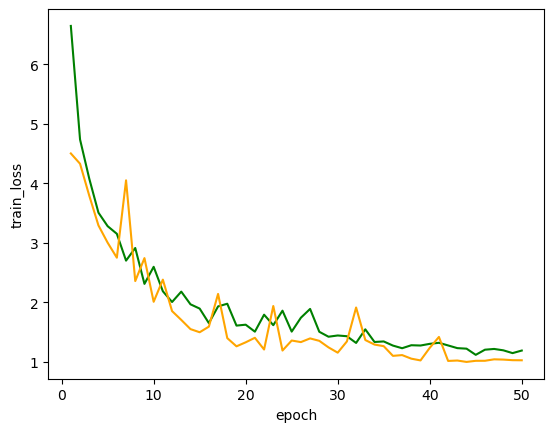

In [18]:
ax = sns.lineplot(history, x="epoch", y="train_loss",color="green")
ax = sns.lineplot(history, x="epoch", y="valid_loss", color="orange")

In [21]:
model.eval()
device="cpu"
model.to(device)

preds = []
target_labels = []
with torch.no_grad():
    for test_batch in test_dataloader:

        outputs = model(node_features= test_batch.node_features, edge_index=test_batch.edge_index, batch_vector=test_batch.batch_vector).squeeze()
        preds.append(outputs)
        target_labels.append(test_batch.targets)

preds = torch.cat(preds)
target_labels = torch.cat(target_labels)

In [22]:
print(f"MAE = {sk_metrics.mean_absolute_error(target_labels, preds)}")
print(f"RMSE = {sk_metrics.root_mean_squared_error(target_labels, preds)}")

MAE = 0.8114164487027855
RMSE = 1.1035300046889271
